In [1]:
def reset(sess):
    sess.close()
    tf.reset_default_graph()

# MAML Regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

## Generate Sine Waves

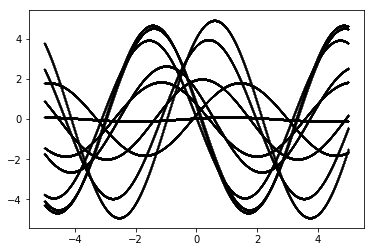

In [3]:
amp = np.random.uniform(0.1, 5.0, size=10)
phase = np.random.uniform(0, np.pi, size=10)

for i in range(10):
    # generate the data
    inputs = np.linspace(-5, 5, 10000)[:, None]
    outputs = amp[i] * np.sin(inputs + phase[i])
    plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')
plt.show()

## MAML Regression Model

In [4]:
def create_model(in_ph, learning_rate=0.01, grads=None, reuse=False):
    
    graph = tf.get_default_graph()

    with tf.variable_scope('fc1', reuse=reuse) as scope:
        tf.contrib.layers.fully_connected(in_ph, 40)  # Create weights and biases
        w = graph.get_tensor_by_name('fc1/fully_connected/weights:0')
        b = graph.get_tensor_by_name('fc1/fully_connected/biases:0')
        w = w - (tf.zeros_like(w)) if grads is None else (learning_rate * grads[w.name])
        b = b - (tf.zeros_like(b)) if grads is None else (learning_rate * grads[b.name])
        network = tf.nn.relu(tf.nn.xw_plus_b(in_ph, w, b))

    with tf.variable_scope('fc2', reuse=reuse):
        tf.contrib.layers.fully_connected(network, 40)
        w = graph.get_tensor_by_name('fc2/fully_connected/weights:0')
        b = graph.get_tensor_by_name('fc2/fully_connected/biases:0')
        w = w - (tf.zeros_like(w)) if grads is None else (learning_rate * grads[w.name])
        b = b - (tf.zeros_like(b)) if grads is None else (learning_rate * grads[b.name])
        network_2 = tf.nn.relu(tf.nn.xw_plus_b(network, w, b))

    with tf.variable_scope('out', reuse=reuse):
        tf.contrib.layers.fully_connected(network_2, 1)
        w = graph.get_tensor_by_name('out/fully_connected/weights:0')
        b = graph.get_tensor_by_name('out/fully_connected/biases:0')
        w = w - (tf.zeros_like(w)) if grads is None else (learning_rate * grads[w.name])
        b = b - (tf.zeros_like(b)) if grads is None else (learning_rate * grads[b.name])
        out_pred = tf.nn.xw_plus_b(network_2, w, b)
    return out_pred

In [5]:
class MAMLTask:
    def __init__(self):
        self.train_in_ph = tf.placeholder(dtype=tf.float32, name='task_train_input', shape=[None, 1])
        self.train_targets = tf.placeholder(dtype=tf.float32, name='task_train_targets', shape=[None, 1])
        self.test_in_ph = tf.placeholder(dtype=tf.float32, name='task_test_input', shape=[None, 1])
        self.test_targets = tf.placeholder(dtype=tf.float32, name='task_test_targets', shape=[None, 1])

        # Take gradient w.r.t overall parameters. Corresponds with lines 6 & 7 of Algorithm 2
        self.out_pred = create_model(self.train_in_ph, reuse=True)
        self.loss = tf.losses.mean_squared_error(self.train_targets, self.out_pred)
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        grads = {var.name: grad for grad, var in zip(tf.gradients(self.loss, weights), weights)}

        # Use gradients for update in line 10
        self.task_out_pred = create_model(self.test_in_ph, grads=grads, reuse=True)
        self.task_loss = tf.losses.mean_squared_error(self.test_targets, self.task_out_pred)


In [6]:
class MAMLNetworkBuilder():
    def __init__(self, num_tasks):
        # Create forward pass for main parameters
        self.in_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.out_pred = create_model(self.in_ph, reuse=False)

        # Create regression loss for fine tuning
        self.targets = tf.placeholder(dtype=tf.float32, name='tune_targets', shape=[None, 1])
        self.loss = tf.losses.mean_squared_error(self.targets, self.out_pred)
        self.adam = tf.train.AdamOptimizer()
        self.opt = self.adam.minimize(self.loss)

        # Generate individual tasks and combined loss (line 10 of Algorithm 2)
        self.tasks = [MAMLTask() for i in range(num_tasks)]
        self.task_loss = tf.reduce_mean([t.task_loss for t in self.tasks])
        self.task_opt = self.adam.minimize(self.task_loss)


In [7]:
tf.reset_default_graph()
meta_iters = 50000
K = 10
meta_batch_size = 25
mnb = MAMLNetworkBuilder(meta_batch_size)

W0820 10:26:26.000239 140243019597632 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0820 10:26:26.385289 140243019597632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
outputs = []
for m in range(meta_iters):
    # Sample batch of tasks
    amp = np.random.uniform(0.1, 5.0, size=meta_batch_size)
    phase = np.random.uniform(0, np.pi, size=meta_batch_size)
    assert len(amp) == meta_batch_size

    # Get train and test data for each task
    test_data = []
    train_data = []
    for t, (a, p) in enumerate(zip(amp, phase)):
        # Sample K datapoints from the task (train/test)
        x = np.random.uniform(-5.0, 5.0, size=K * 2)
        truth = a * np.sin(x + p)
        assert len(truth) == K * 2
        
        train_data.append({'input':np.matrix(x[:K]).transpose(),
                           'truth':np.matrix(truth[:K]).transpose()})
        test_data.append({'input':np.matrix(x[K:]).transpose(),
                           'truth':np.matrix(truth[K:]).transpose()})
    
    assert len(train_data) == meta_batch_size
    assert len(train_data[0]) == 2

        
    # Perform update of parameters
    feed_dict = {}
    task_train_losses = []
    task_test_losses = []
    
    for i,t in enumerate(mnb.tasks):
        feed_dict[t.train_in_ph] = train_data[i]['input']
        feed_dict[t.train_targets] = train_data[i]['truth']

        feed_dict[t.test_in_ph] = test_data[i]['input']
        feed_dict[t.test_targets] = test_data[i]['truth']
        
        task_train_losses.append(t.loss)
        task_test_losses.append(t.task_loss)
    
    output =  sess.run([mnb.task_opt, mnb.task_loss] + task_train_losses + task_test_losses,
                       feed_dict=feed_dict)
    
    outputs.append(output)
    if m % 1000 == 0:
        print(m)
        print(f'Overall loss:{output[1]}\n'
             f'Task Train loss:{output[2]}\n'
             f'Task Test loss:{output[3]}')

0
Overall loss:4.868310928344727
Task Train loss:13.663813591003418
Task Test loss:1.2902555465698242
1000
Overall loss:4.802468776702881
Task Train loss:36.769004821777344
Task Test loss:42.964027404785156
2000
Overall loss:4.669597625732422
Task Train loss:24.71187973022461
Task Test loss:36.11993408203125
3000
Overall loss:3.489311456680298
Task Train loss:29.158935546875
Task Test loss:48.66254425048828
4000
Overall loss:4.5595316886901855
Task Train loss:32.7954216003418
Task Test loss:9.055547714233398
5000
Overall loss:5.507080078125
Task Train loss:25.32268524169922
Task Test loss:37.64670944213867
6000
Overall loss:3.671975612640381
Task Train loss:33.65533447265625
Task Test loss:36.349937438964844
7000
Overall loss:5.103180408477783
Task Train loss:45.057220458984375
Task Test loss:54.26164627075195
8000
Overall loss:4.861575126647949
Task Train loss:48.81169128417969
Task Test loss:59.680458068847656
9000
Overall loss:3.756978750228882
Task Train loss:42.720916748046875
Tas

## Plot loss

In [10]:
overall_loss_data, overall_train_loss, overall_test_loss =zip( *[ (o[1], o[2], o[3]) for o in outputs] )

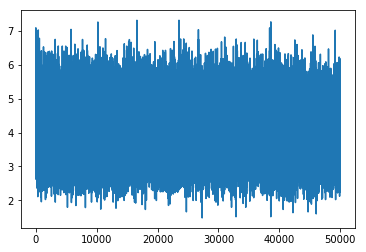

In [11]:
plt.plot(overall_loss_data)

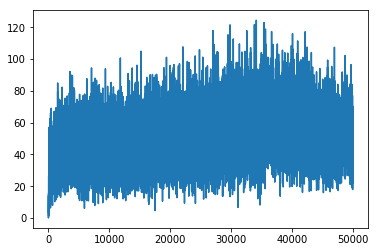

In [12]:
plt.plot(overall_train_loss)

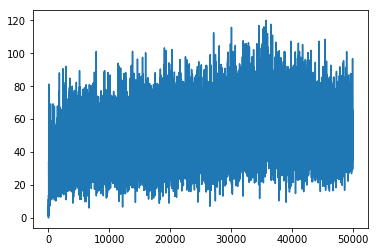

In [13]:
plt.plot(overall_test_loss)

## Test on sine waves

### Copy the network first to avoid overwriting

In [24]:
meta_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
place_holder = [tf.Variable(v) for v in meta_vars]

In [25]:
copy_op = [old.assign(new) for (new, old) in zip(meta_vars, place_holder)]
reset_op =[old.assign(new) for (new, old) in zip(place_holder, meta_vars)]

In [26]:
sess.run(tf.variables_initializer(place_holder))
sess.run(copy_op)

[array([[ 6.89860480e-03, -1.21729255e-01,  1.05326615e-01,
          4.18407209e-02, -6.17511928e-01, -1.64769337e-01,
          4.72109728e-02, -5.06334484e-01,  8.89498591e-02,
          7.43203461e-01, -2.33229905e-01, -2.17004851e-01,
          2.44672105e-01, -4.34209742e-02, -7.02795805e-03,
         -2.18015481e-02, -1.64661542e-01, -1.09688379e-01,
         -1.05463617e-01, -1.46682218e-01, -1.85865209e-01,
          1.28353003e-03, -9.70728099e-02,  6.03840351e-02,
         -2.67163059e-03, -1.08295433e-01, -2.75837541e-01,
          3.26383889e-01, -3.41195017e-02,  5.79361618e-02,
         -8.09490681e-02,  4.79307724e-04, -1.56047523e-01,
         -8.79440904e-02,  3.63039114e-02,  1.24076963e-03,
         -9.79498699e-02,  1.46711599e-02, -7.60607868e-02,
         -8.57568204e-01]], dtype=float32),
 array([ 1.0155457 ,  0.47329566,  1.5094715 ,  0.9515769 , -0.1904651 ,
         0.6326996 ,  1.5989269 , -0.05415162,  0.7588055 ,  0.14346632,
         1.889537  ,  1.712592

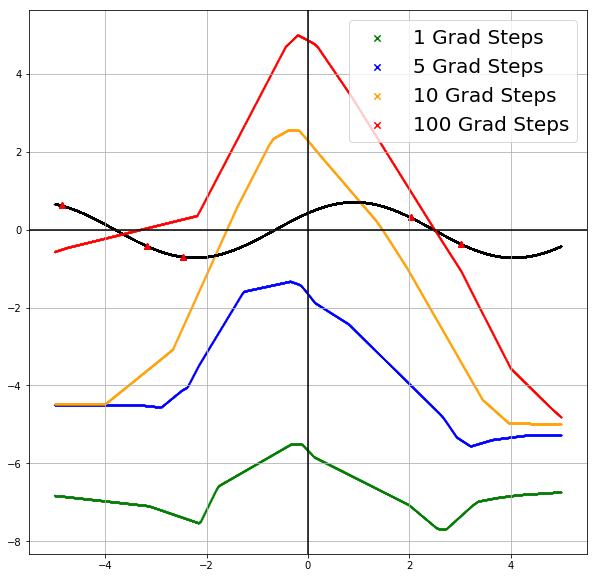

In [30]:
step_list = [1,5,10, 100]
color = ['g', 'b', 'orange', 'red']
# figs, axis = plt.subplots(len(step_list),figsize=(10,len(step_list)*5))
figs, axis = plt.subplots(1,figsize=(10,10))
axis.grid(True, which='both')

axis.axhline(y=0, color='k')
axis.axvline(x=0, color='k')

# Sample one task
amp = np.random.uniform(0.1, 5.0, size=1)
phase = np.random.uniform(0, np.pi, size=1)
inputs = np.linspace(-5, 5, 10000)[:, None]
outputs = amp * np.sin(inputs + phase)
    
# choose K random task training points
x = np.random.uniform(-5.0, 5.0, size=5)
truth = amp * np.sin(x + phase)

# take gradient steps and report results
for i, steps in enumerate(step_list):
    
    # plot truth and training points 
    axis.scatter(inputs[:, 0], outputs[:, 0],
                    s=0.1, color='k', marker='o')
    axis.scatter(x, truth, marker='^', color='red')
    
    # gradient steps
    for s in range(steps):
        _, loss = sess.run([mnb.opt, mnb.loss],
                            feed_dict={mnb.in_ph:np.matrix(x).transpose(),
                                       mnb.targets:np.matrix(truth).transpose()})
    # plot prediction
    pred = sess.run(mnb.out_pred, feed_dict={mnb.in_ph:inputs})
    axis.scatter(inputs[:, 0], pred,
                s=0.1, color=color[i], marker='x', label=f'{step_list[i]} Grad Steps')

    sess.run(reset_op)
    
axis.legend(fontsize=20, markerscale=20)
    # Reset network weights for next trial
